<a href="https://colab.research.google.com/github/AndrewHolm/left-up-acceleration/blob/main/accel_up_left.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np

# Data from arduino (200 1 second samples at 50hz in 3 dimmensions)
# Pull side is a sharp left swipe with the arduino pointed at the screen (y), z least change
# Pull up is a sharp swipe up with arduino starting pointing at screen (y), x least change

# Load the CSV file into a DataFrame
df = pd.read_csv('accel_up_left_data.csv')

# Extract the moving and not moving data into separate arrays
pull_side = df['pull_side'].to_numpy()
pull_up = df['pull_up'].to_numpy()
print(pull_side.shape)

(30000,)


In [39]:
from sklearn.preprocessing import StandardScaler

pull_up = pull_up.reshape(200, 50, 3)
pull_side = pull_side.reshape(200, 50, 3)


# Normalize the data (zero mean and unit variance)
# Reshape the data to have shape (4200*50, 3) for normalization

normalized_data_up = pull_up.reshape(-1, 3)
normalized_data_side = pull_side.reshape(-1, 3)

scaler = StandardScaler()

normalized_data_up = scaler.fit_transform(normalized_data_up)

normalized_data_side = scaler.fit_transform(normalized_data_side)

# Reshape the normalized data back to the original shape (400, 50, 3)
normalized_data_up = normalized_data_up.reshape(pull_up.shape)
normalized_data_side = normalized_data_side.reshape(pull_side.shape)

raw_data = np.concatenate((normalized_data_side, normalized_data_up), axis=0) # combine (400, 50, 3)

# Create labels for the data
num_samples, sample_rate, dim = raw_data.shape # num_samples = 400, sample_rate = 50

# create array for lables, 200 to represent side swipe (0), 200 to represent up swipe (1)
labels = np.concatenate((np.zeros(num_samples//2), np.ones(num_samples//2)))



Epoch 1/10
10/10 [==============================] - 1s 17ms/step - loss: 0.4518 - accuracy: 0.8267 - val_loss: 0.2102 - val_accuracy: 0.9300
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1541 - accuracy: 0.9567 - val_loss: 0.1096 - val_accuracy: 0.9800
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.9900 - val_loss: 0.0698 - val_accuracy: 0.9900
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.0428 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9900
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9900
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9900
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0355 - val_accuracy: 0.9900
Epoch 8/10
10/10 [=

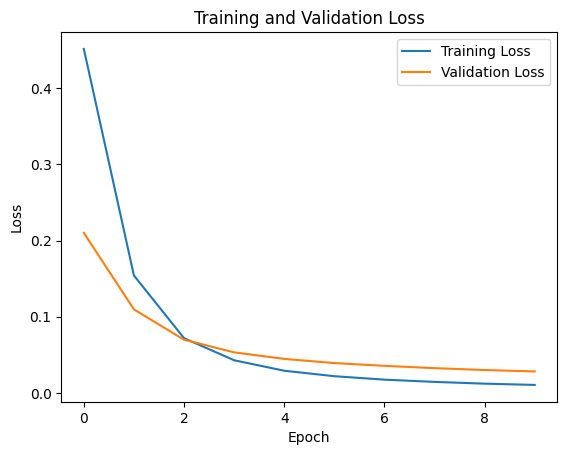

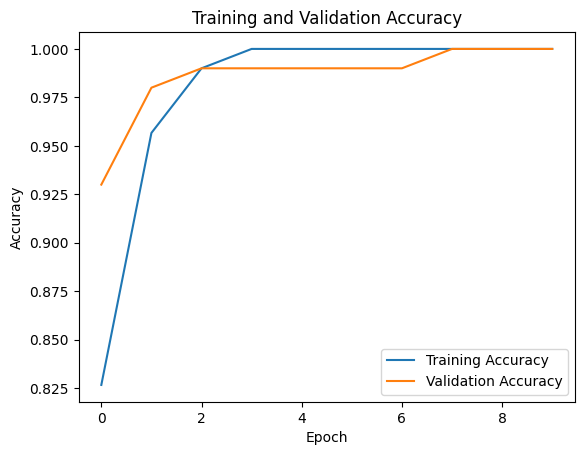

In [40]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

# x_train -> data y_train -> labels, use 75% for training/ 25% for testing 
X_train, X_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.25, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 3)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot the training and validation loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [8]:
# convert the model 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# convert to a c header file 
!apt-get update && apt-get -qq install xxd
!xxd -i model.tflite > accel_model.h

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,354 kB]
Get:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,255 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,774 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal 

In [16]:
# Live test data of left swipe (Normalized on Arduino)

ard_norm_test = np.array([0.02, -0.20, 0.76, 0.01, -0.22, 0.74, 0.01, -0.23, 0.76, 0.02, -0.26, 0.71, 0.02, -0.25, 0.72, 0.01, -0.24, 0.76, 0.00, -0.21, 0.74, -0.02, -0.22, 0.76, -0.04, -0.25, 0.78, -0.05, -0.21, 0.82, -0.03, -0.19, 0.80, -0.01, -0.23, 0.78, 0.04, -0.21, 0.75, 0.08, -0.17, 0.71, 0.11, -0.16, 0.69, 0.08, -0.19, 0.74, 0.04, -0.18, 0.81, 0.02, -0.21, 0.79, 0.01, -0.25, 0.79, 0.06, -0.13, 0.79, 0.04, -0.24, 0.78, 0.01, -0.24, 0.80, 0.01, -0.19, 0.81, 0.02, -0.22, 0.80, -0.02, -0.28, 0.83, -0.05, -0.33, 0.81, -0.05, -0.35, 0.76, -0.03, -0.29, 0.81, -0.04, -0.29, 0.78, -0.04, -0.31, 0.72, -0.01, -0.17, 0.73, -0.06, -0.44, 0.75, -0.14, -0.62, 0.60, -0.38, -1.06, 0.75, -0.72, -1.62, 0.69, -1.11, -2.40, 0.45, -1.83, -3.33, 0.81, -2.36, -3.55, 0.60, -2.78, -2.39, 0.19, -2.74, -1.04, 0.86, -2.55, -0.21, 0.75, -2.34, 0.60, 1.14, -2.02, 0.94, 1.20, -1.98, 0.38, 1.03, -1.84, 1.29, 0.54, -1.28, 2.42, 0.82, -1.18, 1.78, 0.99, -0.99, 2.24, 1.30, -0.82, 1.68, 0.87, -0.74, 1.27, 0.59])

ard_norm_test = ard_norm_test.reshape(1, 50, 3)

print(ard_norm_test.shape)

model.predict(ard_norm_test)

# Arduino prediction = 0.03, "Left"
# Actual Prediction = 0.0347 "Left"

# Live test data of up swipe (Normalized on Arduino)

ard_norm_test2 = np.array([-0.34, -0.36, 1.07, -0.35, -0.35, 1.03, -0.36, -0.38, 1.03, -0.36, -0.37, 1.02, -0.35, -0.36, 1.04, -0.36, -0.36, 1.06, -0.37, -0.38, 1.03, -0.38, -0.39, 1.05, -0.35, -0.34, 1.01, -0.35, -0.39, 1.03, -0.34, -0.39, 0.92, -0.32, -0.38, 0.92, -0.29, -0.41, 0.81, -0.27, -0.40, 0.77, -0.27, -0.35, 0.79, -0.36, -0.38, 0.86, -0.49, -0.45, 1.08, -0.44, -0.47, 1.24, -0.36, -0.40, 1.36, -0.26, -0.39, 1.58, -0.20, -0.40, 1.91, -0.32, -0.42, 2.28, -0.46, -0.40, 2.47, -0.66, -0.21, 3.27, -0.79, -0.02, 3.57, -0.84, 0.04, 3.34, -0.72, 0.10, 1.85, -0.60, -0.04, 1.91, -0.64, -0.07, 1.31, -0.60, -0.26, 1.26, -0.62, -0.46, 1.40, -0.56, -0.52, 0.80, -0.51, -0.54, 0.92, -0.55, -0.55, 0.52, -0.54, -0.80, 1.16, -0.57, -0.59, 1.22, -0.53, -0.56, 0.96, -0.57, -0.42, 0.56, -0.47, -0.37, 0.11, -0.36, -0.22, 0.08, -0.43, -0.44, 0.18, -0.20, 0.15, -0.12, -0.37, 0.13, -0.59, -0.81, -0.36, -1.87, -0.68, -0.10, -3.54, -0.06, -0.09, -2.98, 0.26, 0.07, -1.60, 0.29, 0.33, -1.31, 0.00, 0.21, -2.31, -0.08, -0.02, -2.74])

ard_norm_test2 = ard_norm_test2.reshape(1, 50, 3)

print(ard_norm_test2.shape)

model.predict(ard_norm_test2)

# Arduino prediction = 0.98, "up"
# Actual Prediction = 0.97945714 "up"

(1, 50, 3)
1/1 [==============================] - 0s 29ms/step
(1, 50, 3)
1/1 [==============================] - 0s 29ms/step


array([[0.97945714]], dtype=float32)